# Model Assessment and Selection 1

In this section we will begin the discusion about model selection inside the imbalanced learning context. To begin the discussion let us recall some basic definitions for the binary classification problem.
In general terms, we are interested in extracting information about an **unknown** joint probability distribution $\text{Pr}(X,Y)$ of random variables $X, Y$ from which we have got a sample $\mathcal{D} = \{(x_i, y_i)\}_{i = 1, \dots, N}$ (the dataset), with the random variable $Y$ taking values in $\{0,1\}$. In other words: $y|X = x \sim \text{Bernoulli}(x)$. 
The binary classification problem can be summarized as the problem of finding a function $f: X \longrightarrow \{0,1\}$ defined by:
$$f(x):= \mathbb{P}(Y=1 | X=x),$$
often called **score**. In practice, solving the classification problem implies using an **estimator** function $\hat{f}:X \longrightarrow [0,1]$. It is worth mentioning that the output of this estimator function is not to be interpreted as a probability, in general. A more detailed discussion will be given in the model calibration section.
The classification problem is not entirely solved by finding the best estimator function $\hat{f}$ since in general we could be actually interested in predicting the class to which a particular example belongs, this is, we are looking for an estimator:
$$\hat{y}_{\lambda}(x) = \begin{cases}
                1,\;\; \text{if } \hat{f}(x) \geq \lambda, \\ 
                0, \;\; \text{if } \hat{f}(x) < \lambda
            \end{cases}$$
Following these lines, we can state the problem of **model selection** as trying to answer the following question:
> Given a set of estimators $\{\hat{f}_1, \hat{f}_2, \dots\}$, *what is the best estimator function* $\hat{f}: X \longrightarrow [0,1]$ among them?

What does it mean to be *the best* estimator anyway? We will begin the model selection discussion by trying to answer this question. 

There are different criteria by which several **estimators** could be compared. In practice, however, we are mainly interested in measuring:
* missclassification error or classification metrics
* model complexity and *bias-variance* tradeoff
* training time
* sensitivity to class imbalance
* ...
  
Often, solving a binary classification problem involves optimizing the hyperparameters of inference models. This process can be both computationally intensive and time consuming. Thus, the gain in performance obtained by following this optimization procedure has to justify the effort, otherwise we would choose to go on with a simpler model. To this end, it is always a good practice to compare the results of a complex model with those of a simpler and more interpretable model, usually a logistic regression is selected as the baseline model. 

## Error estimation
There are different measures of missclassification error and choosing one might depend on the nature of the problem, on business criteria and the characteristics of the joint probability distribution $\text{Pr}(X,Y)$. A more detailed discussion is given in the section about losses for binary classification.
Let us consider a classification model $\hat{f}: X \longrightarrow [0,1]$ whose paremeters were estimated using a training set $\mathcal{T} = \{(\mathbb{x}_i, y_i)\}_{i = 1}^{N}$. Consider also an error (loss) function $L: \{0,1\} \times [0,1] \longrightarrow \mathbb{R}_{+}$, such that the missclassification error of a predicted observation $\hat{y} = \hat{f}(x)$, where $x \sim X$ is denoted $L(y, \hat{y})$. One example of such a function and a common choice for binary classification problems is the so called **Binary Cross-Entropy** or **Log Loss**, given by:
\begin{align*}
L = -\dfrac{1}{N}\sum_{i = 1}^{N}\left[y_i \log(\hat{y}_i)+ (1 - y_i)\log(1 - \hat{y}_i)\right]
\end{align*}
where $N$ is the size of the sample $\mathcal{D}$ used for the error estimation, $y_i$ is the $i$-th ground truth value an $\hat{y}_i$ is the $i$-th estimated value (with estimator $\hat{f}$).
The **Test error** or **Generalization error** is the missclassification error calculated on an independent data sample, commonly called *test set*.
\begin{align}
\text{Err}_{\mathcal{T}} = \mathbb{E}\left[L(Y, \hat{f}(X))| \mathcal{T}\right],
\end{align}
note that the training set is fixed, this means that the error estimate is conditioned on the training set choice. We can also average over the training set generation process to get the *expected prediction error*:
\begin{align}
\text{Err} = \mathbb{E}\left[L(Y, \hat{f}(X))\right] = \mathbb{E}\left[\text{Err}_{\mathcal{T}}\right].
\end{align}
**Training error** is nothing else that the missclassification error calculated on the training dataset $\mathcal{T}$,
\begin{align*}
\overline{\text{err}} = \dfrac{1}{N}\sum_{i = 1}^{N}L(y_i, \hat{f}(x_i)).
\end{align*}

### Training error is a bad error estimate!
In order to illustrate how the training error is not a good estimate of the test error let us consider the loss dependance on the model complexity. Consider the case of a binary classification problem, which we are trying to solve using a **logistic regression** or another more complex model (such as a GBDT). We will analyze the behavior of the error estimates for different realizations of the test set $\mathcal{T}$. To do that, let us construct a big dataset (parent distribution) from which we will sample different realizations of the training set. Aditionally, a hold-out dataset (the test dataset) will be sampled a single time from the parent distribution.

In [45]:
import sys
import numpy as np
import pandas as pd

from tqdm import tqdm
from itertools import product
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, precision_recall_curve

sys.path.append('../src/')
from utils import create_imbalanced_binary_classification, run_cross_validation_from_split

In [30]:
def clean_ax(ax, all = False):
    """Clean spines of a matplotlib axis"""
    if all:
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)    
    ax.spines["top"].set_visible(False)
    return ax

In [4]:
n_samples = 10**4
random_state = 42
n_features = 10
data, col_names = create_imbalanced_binary_classification(n_samples = n_samples, n_features = n_features, 
                                                            n_informative = int(n_features/2), imbalance = 0.1,
                                                            random_state = random_state, class_sep = 0.5)
data.target.mean()

0.1039

In [36]:
X = data[col_names]
y = data['target']
X_train_0, X_test, y_train_0, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)
train_sample_size = 0.6
n_trials = 100
max_depths = [2, 3, 5, 8, 15, 30, 50]
results_train = {key: {i: None for i in range(n_trials)} for key in max_depths}
results_test = {key: {i: None for i in range(n_trials)} for key in max_depths}
for n, i in tqdm(product(max_depths, range(n_trials))):
    idx = X_train_0.sample(frac = train_sample_size).index
    X_train = X_train_0.loc[idx]
    y_train = y_train_0.loc[idx]
    # Decision Tree
    # print(f'\tDecision Tree | max_depth = {n}')
    dt_clf = DecisionTreeClassifier(max_depth = n)
    dt_clf.fit(X_train, y_train)
    y_proba = dt_clf.predict_proba(X_test)
    y_proba_train = dt_clf.predict_proba(X_train)
    results_train[n][i] = log_loss(y_train, y_proba_train) 
    results_test[n][i] = log_loss(y_test, y_proba) 

0it [00:00, ?it/s]

In [37]:
results_stats_train = pd.DataFrame({key : {'mean': np.mean(list(results_train[key].values())),
                        'std': np.std(list(results_train[key].values()))} for key in max_depths})
results_stats_test = pd.DataFrame({key : {'mean': np.mean(list(results_test[key].values())),
                        'std': np.std(list(results_test[key].values()))} for key in max_depths})

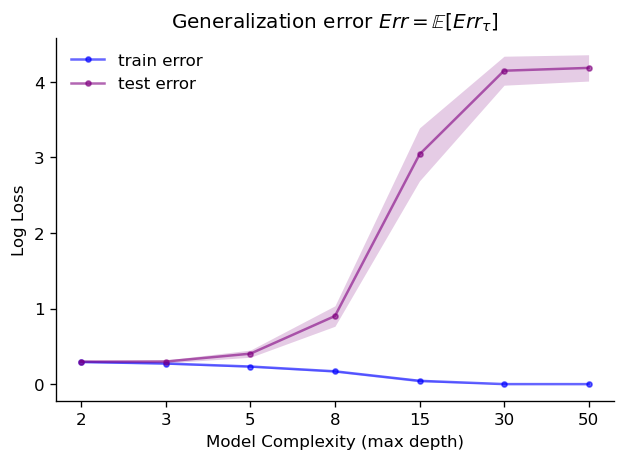

In [38]:
f, ax = plt.subplots(dpi = 120)
x = np.arange(len(max_depths))
ax.plot(x, results_stats_train.loc['mean', :].values,
            marker = '.',
            label = 'train error',
            color = 'b',
            alpha = 0.6)
ax.fill_between(x, 
                y1 = results_stats_train.loc['mean', :].values - results_stats_train.loc['std', :].values,
                y2 = results_stats_train.loc['mean', :].values + results_stats_train.loc['std', :].values,
            color = 'b', alpha = 0.2, linewidth=0)

ax.plot(x, results_stats_test.loc['mean', :].values,
            marker = '.',
            label = 'test error',
            color = 'purple',
            alpha = 0.6)
ax.fill_between(x, 
                y1 = results_stats_test.loc['mean', :].values - results_stats_test.loc['std', :].values,
                y2 = results_stats_test.loc['mean', :].values + results_stats_test.loc['std', :].values,
            color = 'purple', alpha = 0.2, linewidth=0)
ax.set_xticks(x)
ax.set_xticklabels(max_depths)
ax.set_xlabel('Model Complexity (max depth)')
ax.set_ylabel('Log Loss')
ax.legend(loc = 'best', frameon = False)
ax.set_title(r'Generalization error $Err = \mathbb{E}[Err_{\tau}]$')
clean_ax(ax)
plt.show()

The amount by which the training error and the true error differ is often called **optimism**. There are several ways of seeing this. To construct the above figure we used a held-out dataset (not seen in the training process) to compute the *true error*. Another common estimate of the true *training* error is often called **in-sample error**:
$$\text{Err}_{\text{in}} = \dfrac{1}{N}\sum_{i=1}^{N}\mathbb{E}_{Y^0}[L(Y_{i}^0), \hat{f}(x_i)|\mathcal{T}],$$
where $Y^0$ stands for the distribution of all possible target values (in the training dataset). This is, for each observation $x_i$ we compute the expected error over the distribution of all possible outcomes $Y^0_i$. The optimism is defined as:
\begin{align*}
\text{op} := \text{Err}_{\text{in}} - \overline{\text{err}}.
\end{align*}
Thus, a way of solving the error underestimation problem is to estimate the optimism $\text{op}$ and add this value to the training error $\text{err}$ so the underestimation gets "corrected". There are several methods that treat the error underestimation problem this way such as the *Akaike information criterion* (AIC), the *Bayesian information criterion* and the $C_p$-*statistic*. We refer the reader to [Tibshirani] for a detailed discussion about these techniques. We will rather focus our discussion in the usual way this problem is tackled in practice, this is, Cross Validation and Bootstrap.

Let us see another example where we use an ensemble of decision trees, such as gradient boosted ensemble of decision trees. We are interested in the training-test error gap as the number of weak learners increases. 

In [42]:
n_samples = 10**3
random_state = 42
n_features = 10
data, col_names = create_imbalanced_binary_classification(n_samples = n_samples, n_features = n_features, 
                                                        n_informative = int(n_features/2), imbalance = 0.1,
                                                        random_state = random_state, class_sep = 0.5)
parent_positive_rate = data.target.mean()
X = data[col_names]
y = data['target']
X_train_0, X_test, y_train_0, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)
train_sample_size = 0.5
n_trials = 10
n_estimators = [3, 6, 10, 20, 50, 100, 150]
results_train = {key: {i: None for i in range(n_trials)} for key in n_estimators}
results_test = {key: {i: None for i in range(n_trials)} for key in n_estimators}
for n, i in product(n_estimators, range(n_trials)):
    idx = X_train_0.sample(frac = train_sample_size).index
    X_train = X_train_0.loc[idx]
    y_train = y_train_0.loc[idx]
    # Model training
    clf = LGBMClassifier(n_estimators = n)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)
    y_proba_train = clf.predict_proba(X_train)
    results_train[n][i] = log_loss(y_train, y_proba_train) 
    results_test[n][i] = log_loss(y_test, y_proba)
# Get results for plotting
results_stats_train = pd.DataFrame({key : {'mean': np.mean(list(results_train[key].values())),
                    'std': np.std(list(results_train[key].values()))} for key in n_estimators})
results_stats_test = pd.DataFrame({key : {'mean': np.mean(list(results_test[key].values())),    
                    'std': np.std(list(results_test[key].values()))} for key in n_estimators})

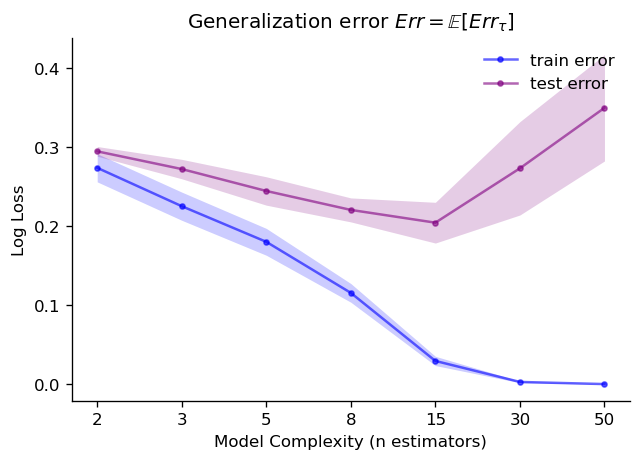

In [43]:
f, ax = plt.subplots(dpi = 120)
x = np.arange(len(n_estimators))
ax.plot(x, results_stats_train.loc['mean', :].values,
            marker = '.',
            label = 'train error',
            color = 'b',
            alpha = 0.6)
ax.fill_between(x, 
                y1 = results_stats_train.loc['mean', :].values - results_stats_train.loc['std', :].values,
                y2 = results_stats_train.loc['mean', :].values + results_stats_train.loc['std', :].values,
            color = 'b', alpha = 0.2, linewidth=0)

ax.plot(x, results_stats_test.loc['mean', :].values,
            marker = '.',
            label = 'test error',
            color = 'purple',
            alpha = 0.6)
ax.fill_between(x, 
                y1 = results_stats_test.loc['mean', :].values - results_stats_test.loc['std', :].values,
                y2 = results_stats_test.loc['mean', :].values + results_stats_test.loc['std', :].values,
            color = 'purple', alpha = 0.2, linewidth=0)
ax.set_xticks(x)
ax.set_xticklabels(max_depths)
ax.set_xlabel('Model Complexity (n estimators)')
ax.set_ylabel('Log Loss')
ax.legend(loc = 'best', frameon = False)
ax.set_title(r'Generalization error $Err = \mathbb{E}[Err_{\tau}]$')
clean_ax(ax)
plt.show()

The above figure shows that the training error severely understimates the test (true) error value as the model becomes more complex, commonly known as *overfitting*. The effect is diminished as the training dataset size grows. The most widely used method to turnaround this error underestimation problem is known as **Cross-Validation** (CV). This method directly estimates the *extra-sample* error $\text{Err} = \mathbb{E}[L(Y, \hat{f}(X))]$, where $(X,Y)$ is a *test* sample from the joint distribution $p(X,Y)$. In k-fold CV the training dataset $\mathcal{T}$ is split into k mutually-exclusive similar subsets $\{\mathcal{T}_1,\mathcal{T}_2, \dots, \mathcal{T}_k\}$. At each CV round, a different fold is left out of the training procedure and used as a testing set. The error (loss) is then averaged across all folds to obtain the generalization error estimate. To see this, let $\kappa: \{i\}_{i=1}^{N} \rightarrow \{k\}_{k=1}^{K}$ be a mapping function that assigns a fold $k$ to each observation $i$. Furthermore, let us write as $\mathcal{T}_k$ the fold that is left out of the training procedure, the model obtained by fitting on the rest of the folds is then denoted as $\hat{f}^{-k}(x)$. Then we can write the cross-validation estimate of missclassification error as:
\begin{align*}
\widehat{\text{Err}}_{\text{CV}}(\hat{f}) = \dfrac{1}{N}\sum_{i = 1}^{N} L(y_i, \hat{f}^{-\kappa (i)}(x_i))
\end{align*}
The cross validation estimate is a random number that depends on the division into the k-folds. The extreme case where $k = n$ is known as **leave-one-out** cross validation, since a single entity is left out of the training set for each fold and the fit is computed on all the rest observations. This can turn the method more computationally costly as the size of the training dataset grows. The choice for the number of splits is discussed in [kohavi](http://ai.stanford.edu/~ronnyk/accEst.pdf), stratified ten-fold cross-validation being the most common recommendation. 

Often CV is also used as a method for evaluating different hyperparameters of the classification model. In this scenario, consider a set of different models all indexed by a (set of) parameter(s) $\{\xi\}$ such as regularization weights or the number of estimators for ensemble methods. We denote the model whose fit was computed using all but the $k$-th fold as $\hat{f}^{-k}(x,\xi)$ so we can write:
\begin{align*}
\widehat{\text{Err}}_{CV}(\hat{f}, \xi) = \dfrac{1}{N} \sum_{i = 1}^{N}L(y_i, \hat{f}^{-\kappa(i)}(x_i, \xi)),
\end{align*}
for the cross-validation error estimate. This error estimate can be used to select the parameter $\hat{\xi}$ for which the above quantity is minimum. The model $\hat{f}(x, \hat{\xi})$ is then chosen as the final model.

In the following experiment we will try to estimate the true error [<sup id="fn1">1</sup>](#fn1) using the cross validation strategy in two variations, the first one is a simple 10-fold cross validation strategy while the second one consists on a *repeated* 10-fold cross validation.


[<sup id="fn1">1</sup>](#fn1) Computed on a held-out validation sample that is never seen in the training procedure.

### 10-fold Cross Validation

In [15]:
model = LGBMClassifier(max_depth= 3)
n_folds = 10
X = data[col_names]
y = data['target']
# Sample validation test set 
X_dev, X_valid, y_dev, y_valid = train_test_split(X, y, test_size = 0.3)
# KFold cross validation
skf = StratifiedKFold(n_folds)
results_cv = run_cross_validation_from_split(model = model, 
                                                kfold = skf,
                                                X_dev = X_dev,
                                                y_dev = y_dev, 
                                                X_valid = X_valid, 
                                                y_valid = y_valid)

### Repeated Cross Validation

In [14]:
model = LGBMClassifier(max_depth = 3)
rskf = RepeatedStratifiedKFold(n_splits = n_folds, n_repeats = 10)
results_repeated_cv = run_cross_validation_from_split(model, kfold = rskf, 
                                                        X_dev = X_dev, y_dev = y_dev,
                                                        X_valid = X_valid, y_valid = y_valid)

'RepeatedStratifiedKFold' object has no attribute 'n_splits'


In [16]:
df_results_cv = pd.DataFrame(results_cv).T
df_results_repeated_cv  = pd.DataFrame(results_repeated_cv).T
# For the repeated cross validation results, we need to average over each repetition
df_results_repeated_cv['rep'] = df_results_repeated_cv.reset_index()['index'].astype(int).apply(lambda x: int((x-1)/10)).values
df_results_rep_summarized = df_results_repeated_cv.groupby('rep').mean()

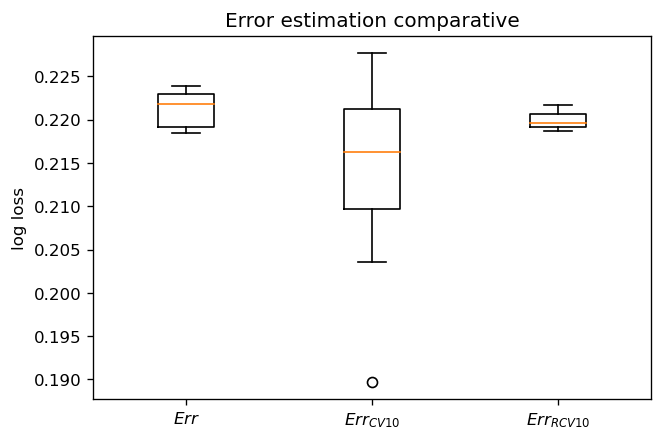

In [17]:
errors = [df_results_cv['valid'].values,\
         df_results_cv['test'].values,\
         df_results_rep_summarized['test']]
x_labels = [r'$Err$',\
            r'$Err_{CV10}$',\
            r'$Err_{RCV10}$']
f, ax = plt.subplots(dpi = 120)
ax.boxplot(errors)
ax.set_xticklabels(x_labels)
ax.set_ylabel('log loss')
ax.set_title('Error estimation comparative')
plt.show()


The above figure shows that both 10-fold cross validation and the repeated cross validation are slightly biased. However, the repeated version has less variance and thus it is a better estimate of the true error. Let us explore the impact of different imbalance ratios on the error estimation both by using the simple 10-fold CV and the repeated CV strategies. For that, we will use a gradient boosting ensemble of decision trees as the classification algorithm.

In [44]:
n_samples = 10**4
n_features = 6
n_informative = 3
class_sep = 0.5
cv_results = {}
imbalances = [0.5, 0.2, 0.1, 0.05, 0.01, 5e-3, 1e-3]
random_state = 42
for imbalance in tqdm(imbalances):
    cv_results[imbalance] = {}
    # Create dataset
    data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance,
                                        class_sep = class_sep)
    X = data[column_names]
    y = data['target']
    # Sample validation test set 
    X_dev, X_valid, y_dev, y_valid = train_test_split(X, y, test_size = 0.3)
    # 10-Fold CV experiment
    n_folds = 10
    model = LGBMClassifier(max_depth= 3)
    skf = StratifiedKFold(n_folds)
    cv_results[imbalance]['CV10'] = pd.DataFrame(run_cross_validation_from_split(model = model, 
                                                                        kfold = skf,
                                                                        X_dev = X_dev,
                                                                        y_dev = y_dev, 
                                                                        X_valid = X_valid, 
                                                                        y_valid = y_valid)).T
    # Repeated CV experiment
    model = LGBMClassifier(max_depth = 3)
    rskf = RepeatedStratifiedKFold(n_splits = n_folds, n_repeats = 10)
    cv_results[imbalance]['RCV10'] = pd.DataFrame(run_cross_validation_from_split(model, kfold = rskf, 
                                                            X_dev = X_dev, y_dev = y_dev,
                                                            X_valid = X_valid, y_valid = y_valid)).T

  0%|          | 0/7 [00:00<?, ?it/s]

'RepeatedStratifiedKFold' object has no attribute 'n_splits'
'RepeatedStratifiedKFold' object has no attribute 'n_splits'
'RepeatedStratifiedKFold' object has no attribute 'n_splits'
'RepeatedStratifiedKFold' object has no attribute 'n_splits'
'RepeatedStratifiedKFold' object has no attribute 'n_splits'
'RepeatedStratifiedKFold' object has no attribute 'n_splits'
'RepeatedStratifiedKFold' object has no attribute 'n_splits'


In [65]:
cv_results[0.5]['RCV10']['rep'] = cv_results[0.5]['RCV10'].reset_index()['index'].astype(int).apply(lambda x: int((x-1)/10)).values
cv_results[0.5]['RCV10']['rep']

<AxesSubplot:>

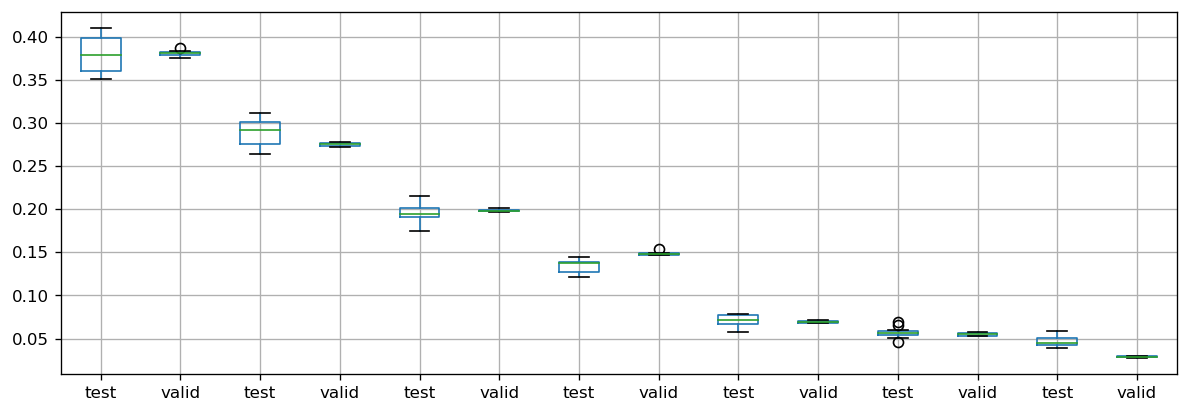

In [47]:
f, ax = plt.subplots(dpi = 120, figsize = (12,4))
pd.concat([cv_results[imbalance]['CV10'] for imbalance in imbalances], axis = 1).boxplot(ax = ax)

<AxesSubplot:>

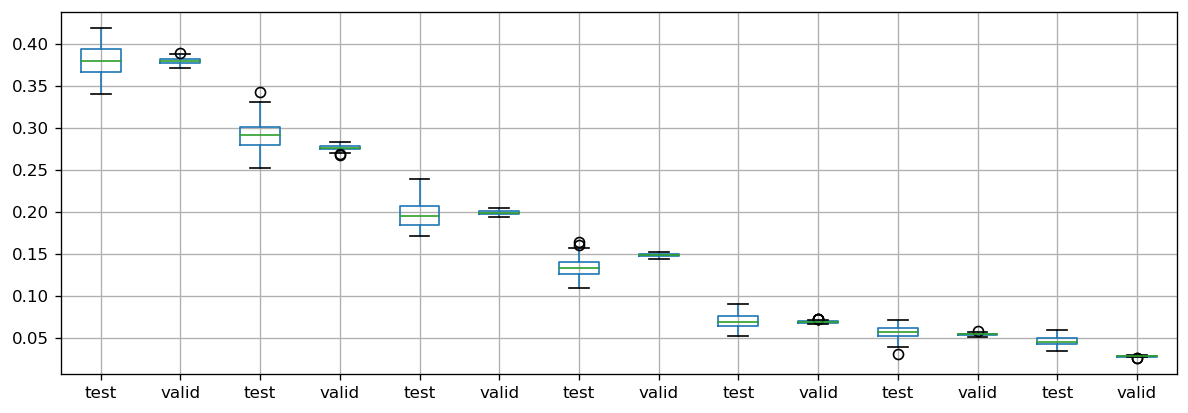

In [49]:
f, ax = plt.subplots(dpi = 120, figsize = (12,4))
pd.concat([cv_results[imbalance]['RCV10'] for imbalance in imbalances], axis = 1).boxplot(ax = ax)